In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights, ConvNeXt_Tiny_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
from typing import Dict
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
import shutil

In [53]:
# Data Augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Augmentation for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [54]:
train_dataset = datasets.ImageFolder(root='data/pellis_training/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='data/pellis_training/test', transform=test_transforms)

In [55]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Caminho para o diretório de treino
train_dir_path = Path('/kaggle/input/dataset-original/pellis_training/train')

# Lista de imagens no diretório de treino
train_images = list(train_dir_path.rglob('*/*.jpg'))

# Seleciona uma imagem aleatoriamente
img_path = np.random.choice(train_images)

# Carrega a imagem
img = Image.open(img_path)

# Obtendo o nome da classe
class_name = img_path.parent.name

# Exibe a imagem
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Caminho para o diretório de treino
test_dir_path = Path('/kaggle/input/dataset-original/pellis_training/test')

# Lista de imagens no diretório de treino
test_images = list(test_dir_path.rglob('*/*.jpg'))

# Seleciona uma imagem aleatoriamente
img_path = np.random.choice(test_images)

# Carrega a imagem
img = Image.open(img_path)

# Obtendo o nome da classe
class_name = img_path.parent.name

# Exibe a imagem
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


In [ ]:
img_array = np.array(img)

# Plotting with matplotlib
plt.imshow(img_array)
plt.title(f'Image class: {class_name} | Image shape: {img_array.shape} -> (H, W, C)')
plt.axis('off')

In [ ]:
# Testing transforms on the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original Image | {img_array.shape} -> (H, W, C)')

# Apply transforms
img_tensor = train_transforms(img)
img_tensor = img_tensor.numpy().transpose((1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(img_tensor)
plt.axis('off')
plt.title(f'Transformed Image | {img_tensor.shape} -> (H, W, C)')
plt.show()

In [56]:
# Getting class names from the training dataset as a list
class_names = train_dataset.classes

class_names

['1', '2 profundo', '2 superficial', '3', 'Não queimadura']

In [57]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Cria os carregadores de dados
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         pin_memory=True)

# Inspecionar os rótulos no DataLoader
for images, labels in train_loader:
    unique_labels = set(labels.cpu().numpy())
    print(f"Unique labels in train_loader: {unique_labels}")
    break

for images, labels in test_loader:
    unique_labels = set(labels.cpu().numpy())
    print(f"Unique labels in test_loader: {unique_labels}")
    break

print(f"Number of classes in train_dataset: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")

Unique labels in train_loader: {0, 1, 2, 3, 4}
Unique labels in test_loader: {0}
Number of classes in train_dataset: 5
Class names: ['1', '2 profundo', '2 superficial', '3', 'Não queimadura']


In [58]:
# Getting first batch of data
img, label = next(iter(train_loader))

# Checking the shape of the image and label
img.shape, label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [59]:
from torchvision.models import densenet161, DenseNet161_Weights

# Carrega os pesos do ImageNet
weights = DenseNet161_Weights.IMAGENET1K_V1

# Inicializa o modelo com os pesos
model = densenet161(weights=weights)


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\VORTEX/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|███████████████████████████████| 110M/110M [00:08<00:00, 13.8MB/s]


In [66]:
import torch.nn as nn

# Congelar as camadas da ResNet50
for param in model.parameters():
    param.requires_grad = False

# Se o modelo tiver só um Linear, pegue o .in_features diretamente
num_ftrs = model.classifier.in_features
num_classes = len(train_dataset.classes)

class ModifiedConvNext(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ModifiedConvNext, self).__init__()
        self.base_model = base_model
        self.base_model.classifier = nn.Identity()  # Remove the original classifier
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),  # 3 classes para queimaduras de grau 1, 2 e 3
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


In [67]:

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Outras camadas do teu modelo
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(196608, 512)  # Ajusta esse valor conforme necessário
        self.fc2 = nn.Linear(512, num_classes)  # num_classes é o número de classes que você tem

    def forward(self, x):
        # Passa por outras camadas do teu modelo
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x


In [68]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = ModifiedConvNext(model, num_classes).to(device)


In [69]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device) -> Dict[str, float]:
    # Assuring that the model is in device (GPU or CPU)
    model.to(device)

    # Set the model to train mode
    model.train()

    # Initialize loss and metrics
    train_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_preds, all_labels = [], []

    # Looping through the dataloader
    for images, labels in dataloader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate the accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data).item()
        total_predictions += len(preds)

        # Collect predictions and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and accuracy
    train_loss /= len(dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score
    train_precision = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_f1 = f1_score(all_labels, all_preds, average='macro')

    return {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1
    }

In [70]:
def testing_step(model: nn.Module,
                 dataloader: DataLoader,
                 loss_fn: nn.Module,
                 device: torch.device) -> Dict[str, float]:
    # Assuring that the model is in device (GPU or CPU)
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Initialize loss and metrics
    test_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_preds, all_labels = [], []

    # Looping through the dataloader
    with torch.inference_mode():
        for images, labels in dataloader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate the accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data).item()
            total_predictions += len(preds)

            # Collect predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and accuracy
    test_loss /= len(dataloader)
    test_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }

In [71]:
def training(model: nn.Module,
             train_loader: DataLoader,
             test_loader: DataLoader,
             loss_fn: nn.Module,
             optimizer: optim.Optimizer,
             device: torch.device,
             num_epochs: int) -> Dict[str, float]:
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': []
    }

    for epoch in tqdm(range(num_epochs)):
        train_results = train_step(model, train_loader, loss_fn, optimizer, device)
        test_results = testing_step(model, test_loader, loss_fn, device)
        
        history['train_loss'].append(train_results['train_loss'])
        history['train_accuracy'].append(train_results['train_accuracy'])
        history['train_precision'].append(train_results['train_precision'])
        history['train_recall'].append(train_results['train_recall'])
        history['train_f1'].append(train_results['train_f1'])
        
        history['test_loss'].append(test_results['test_loss'])
        history['test_accuracy'].append(test_results['test_accuracy'])
        history['test_precision'].append(test_results['test_precision'])
        history['test_recall'].append(test_results['test_recall'])
        history['test_f1'].append(test_results['test_f1'])
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)
        print(f"""
              Train Loss: {train_results['train_loss']:.4f}, 
              Train Accuracy: {train_results['train_accuracy']:.4f},
              Train Precision: {train_results['train_precision']:.4f}, 
              Train Recall: {train_results['train_recall']:.4f}, 
              Train F1: {train_results['train_f1']:.4f}
          """)
        print(f"""
              Test Loss: {test_results['test_loss']:.4f}, 
              Test Accuracy: {test_results['test_accuracy']:.4f}, 
              Test Precision: {test_results['test_precision']:.4f}, 
              Test Recall: {test_results['test_recall']:.4f}, 
              Test F1: {test_results['test_f1']:.4f}
          """)
        print()

    return history

In [72]:
for images, labels in train_loader:
    print(images.shape)
    break


torch.Size([32, 3, 256, 256])


In [73]:
import torch
import torch.nn as nn  # Importa o módulo nn aqui
import torch.optim as optim
from tqdm import tqdm


# Define a função de perda
loss_fn = nn.CrossEntropyLoss()

# Adiciona isso no começo do código, junto com as outras importações
from time import time

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
NUM_EPOCHS = 30
start_time = time()
model_results = training(model, train_loader, test_loader, loss_fn, optimizer, device, NUM_EPOCHS)
end_time = time()

total_time = end_time - start_time
print(f'Total training time: {total_time // 60:.0f}m {total_time % 60:.0f}s')
print("Training results: ", model_results)


  0%|                                           | 0/30 [00:00<?, ?it/s]C:\Users\VORTEX\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|█▏                                 | 1/30 [01:00<29:12, 60.43s/it]

Epoch 1/30
--------------------

              Train Loss: 1.3898, 
              Train Accuracy: 0.4332,
              Train Precision: 0.2956, 
              Train Recall: 0.2424, 
              Train F1: 0.2121
          

              Test Loss: 1.2135, 
              Test Accuracy: 0.5039, 
              Test Precision: 0.3876, 
              Test Recall: 0.3887, 
              Test F1: 0.3719
          



  7%|██▎                                | 2/30 [02:00<27:59, 59.99s/it]

Epoch 2/30
--------------------

              Train Loss: 1.1493, 
              Train Accuracy: 0.5206,
              Train Precision: 0.4819, 
              Train Recall: 0.4031, 
              Train F1: 0.4210
          

              Test Loss: 1.0783, 
              Test Accuracy: 0.5276, 
              Test Precision: 0.4877, 
              Test Recall: 0.4205, 
              Test F1: 0.4051
          



C:\Users\VORTEX\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|███▌                               | 3/30 [02:59<26:49, 59.60s/it]

Epoch 3/30
--------------------

              Train Loss: 1.0855, 
              Train Accuracy: 0.5410,
              Train Precision: 0.4868, 
              Train Recall: 0.4450, 
              Train F1: 0.4566
          

              Test Loss: 1.0880, 
              Test Accuracy: 0.5236, 
              Test Precision: 0.4229, 
              Test Recall: 0.4333, 
              Test F1: 0.3845
          



 13%|████▋                              | 4/30 [03:58<25:46, 59.48s/it]

Epoch 4/30
--------------------

              Train Loss: 1.0085, 
              Train Accuracy: 0.5807,
              Train Precision: 0.5452, 
              Train Recall: 0.5023, 
              Train F1: 0.5174
          

              Test Loss: 1.0716, 
              Test Accuracy: 0.5354, 
              Test Precision: 0.5304, 
              Test Recall: 0.3996, 
              Test F1: 0.4116
          



 17%|█████▊                             | 5/30 [04:58<24:49, 59.59s/it]

Epoch 5/30
--------------------

              Train Loss: 0.9520, 
              Train Accuracy: 0.6061,
              Train Precision: 0.5780, 
              Train Recall: 0.5272, 
              Train F1: 0.5459
          

              Test Loss: 1.0630, 
              Test Accuracy: 0.5276, 
              Test Precision: 0.5522, 
              Test Recall: 0.4198, 
              Test F1: 0.4413
          



 20%|███████                            | 6/30 [05:57<23:49, 59.58s/it]

Epoch 6/30
--------------------

              Train Loss: 0.9324, 
              Train Accuracy: 0.6314,
              Train Precision: 0.6122, 
              Train Recall: 0.5677, 
              Train F1: 0.5852
          

              Test Loss: 1.0136, 
              Test Accuracy: 0.5433, 
              Test Precision: 0.5055, 
              Test Recall: 0.4888, 
              Test F1: 0.4538
          



 23%|████████▏                          | 7/30 [06:58<22:55, 59.79s/it]

Epoch 7/30
--------------------

              Train Loss: 0.9187, 
              Train Accuracy: 0.6180,
              Train Precision: 0.5862, 
              Train Recall: 0.5500, 
              Train F1: 0.5635
          

              Test Loss: 1.0158, 
              Test Accuracy: 0.5669, 
              Test Precision: 0.5213, 
              Test Recall: 0.5602, 
              Test F1: 0.4882
          



 27%|█████████▎                         | 8/30 [07:57<21:51, 59.63s/it]

Epoch 8/30
--------------------

              Train Loss: 0.8499, 
              Train Accuracy: 0.6518,
              Train Precision: 0.6290, 
              Train Recall: 0.5963, 
              Train F1: 0.6060
          

              Test Loss: 1.0483, 
              Test Accuracy: 0.5650, 
              Test Precision: 0.4814, 
              Test Recall: 0.5544, 
              Test F1: 0.4816
          



 30%|██████████▌                        | 9/30 [08:57<20:52, 59.65s/it]

Epoch 9/30
--------------------

              Train Loss: 0.8214, 
              Train Accuracy: 0.6642,
              Train Precision: 0.6514, 
              Train Recall: 0.6146, 
              Train F1: 0.6291
          

              Test Loss: 0.9762, 
              Test Accuracy: 0.5886, 
              Test Precision: 0.5628, 
              Test Recall: 0.5878, 
              Test F1: 0.5729
          



 33%|███████████▎                      | 10/30 [09:57<19:55, 59.77s/it]

Epoch 10/30
--------------------

              Train Loss: 0.7849, 
              Train Accuracy: 0.6910,
              Train Precision: 0.6741, 
              Train Recall: 0.6489, 
              Train F1: 0.6588
          

              Test Loss: 1.0246, 
              Test Accuracy: 0.5689, 
              Test Precision: 0.5572, 
              Test Recall: 0.5632, 
              Test F1: 0.4993
          



 37%|████████████▍                     | 11/30 [10:56<18:54, 59.74s/it]

Epoch 11/30
--------------------

              Train Loss: 0.7990, 
              Train Accuracy: 0.6885,
              Train Precision: 0.6774, 
              Train Recall: 0.6378, 
              Train F1: 0.6541
          

              Test Loss: 1.0022, 
              Test Accuracy: 0.5807, 
              Test Precision: 0.5460, 
              Test Recall: 0.5871, 
              Test F1: 0.5532
          



 40%|█████████████▌                    | 12/30 [11:56<17:54, 59.69s/it]

Epoch 12/30
--------------------

              Train Loss: 0.7330, 
              Train Accuracy: 0.7104,
              Train Precision: 0.7033, 
              Train Recall: 0.6744, 
              Train F1: 0.6860
          

              Test Loss: 0.9900, 
              Test Accuracy: 0.5945, 
              Test Precision: 0.5704, 
              Test Recall: 0.5999, 
              Test F1: 0.5608
          



 43%|██████████████▋                   | 13/30 [12:55<16:52, 59.58s/it]

Epoch 13/30
--------------------

              Train Loss: 0.7255, 
              Train Accuracy: 0.7273,
              Train Precision: 0.7204, 
              Train Recall: 0.6866, 
              Train F1: 0.7015
          

              Test Loss: 0.9901, 
              Test Accuracy: 0.5984, 
              Test Precision: 0.5779, 
              Test Recall: 0.5091, 
              Test F1: 0.5250
          



 47%|███████████████▊                  | 14/30 [13:54<15:51, 59.48s/it]

Epoch 14/30
--------------------

              Train Loss: 0.6846, 
              Train Accuracy: 0.7352,
              Train Precision: 0.7281, 
              Train Recall: 0.7055, 
              Train F1: 0.7155
          

              Test Loss: 1.1111, 
              Test Accuracy: 0.5965, 
              Test Precision: 0.6049, 
              Test Recall: 0.4943, 
              Test F1: 0.5157
          



 50%|█████████████████                 | 15/30 [14:54<14:53, 59.58s/it]

Epoch 15/30
--------------------

              Train Loss: 0.6477, 
              Train Accuracy: 0.7377,
              Train Precision: 0.7301, 
              Train Recall: 0.6978, 
              Train F1: 0.7115
          

              Test Loss: 1.0385, 
              Test Accuracy: 0.5906, 
              Test Precision: 0.5781, 
              Test Recall: 0.5623, 
              Test F1: 0.5515
          



 53%|██████████████████▏               | 16/30 [15:54<13:54, 59.60s/it]

Epoch 16/30
--------------------

              Train Loss: 0.6538, 
              Train Accuracy: 0.7407,
              Train Precision: 0.7313, 
              Train Recall: 0.7140, 
              Train F1: 0.7214
          

              Test Loss: 0.9716, 
              Test Accuracy: 0.6004, 
              Test Precision: 0.5894, 
              Test Recall: 0.5619, 
              Test F1: 0.5617
          



 57%|███████████████████▎              | 17/30 [16:53<12:54, 59.57s/it]

Epoch 17/30
--------------------

              Train Loss: 0.6591, 
              Train Accuracy: 0.7437,
              Train Precision: 0.7351, 
              Train Recall: 0.7087, 
              Train F1: 0.7193
          

              Test Loss: 0.9812, 
              Test Accuracy: 0.5827, 
              Test Precision: 0.5609, 
              Test Recall: 0.5730, 
              Test F1: 0.5518
          



 60%|████████████████████▍             | 18/30 [17:53<11:54, 59.53s/it]

Epoch 18/30
--------------------

              Train Loss: 0.6619, 
              Train Accuracy: 0.7447,
              Train Precision: 0.7347, 
              Train Recall: 0.7146, 
              Train F1: 0.7233
          

              Test Loss: 0.9896, 
              Test Accuracy: 0.6142, 
              Test Precision: 0.5850, 
              Test Recall: 0.5873, 
              Test F1: 0.5839
          



 63%|█████████████████████▌            | 19/30 [18:53<10:55, 59.57s/it]

Epoch 19/30
--------------------

              Train Loss: 0.5767, 
              Train Accuracy: 0.7700,
              Train Precision: 0.7647, 
              Train Recall: 0.7326, 
              Train F1: 0.7471
          

              Test Loss: 1.0307, 
              Test Accuracy: 0.5807, 
              Test Precision: 0.5808, 
              Test Recall: 0.5496, 
              Test F1: 0.5554
          



 67%|██████████████████████▋           | 20/30 [19:52<09:54, 59.43s/it]

Epoch 20/30
--------------------

              Train Loss: 0.6055, 
              Train Accuracy: 0.7601,
              Train Precision: 0.7534, 
              Train Recall: 0.7287, 
              Train F1: 0.7399
          

              Test Loss: 1.0203, 
              Test Accuracy: 0.5945, 
              Test Precision: 0.5730, 
              Test Recall: 0.5760, 
              Test F1: 0.5664
          



 70%|███████████████████████▊          | 21/30 [20:51<08:55, 59.52s/it]

Epoch 21/30
--------------------

              Train Loss: 0.6324, 
              Train Accuracy: 0.7437,
              Train Precision: 0.7298, 
              Train Recall: 0.7159, 
              Train F1: 0.7222
          

              Test Loss: 1.0872, 
              Test Accuracy: 0.5925, 
              Test Precision: 0.6133, 
              Test Recall: 0.5121, 
              Test F1: 0.5319
          



 73%|████████████████████████▉         | 22/30 [21:51<07:56, 59.58s/it]

Epoch 22/30
--------------------

              Train Loss: 0.5912, 
              Train Accuracy: 0.7620,
              Train Precision: 0.7520, 
              Train Recall: 0.7311, 
              Train F1: 0.7404
          

              Test Loss: 1.1140, 
              Test Accuracy: 0.6102, 
              Test Precision: 0.6033, 
              Test Recall: 0.5635, 
              Test F1: 0.5765
          



 77%|██████████████████████████        | 23/30 [22:51<06:57, 59.63s/it]

Epoch 23/30
--------------------

              Train Loss: 0.5938, 
              Train Accuracy: 0.7685,
              Train Precision: 0.7695, 
              Train Recall: 0.7459, 
              Train F1: 0.7568
          

              Test Loss: 1.2072, 
              Test Accuracy: 0.5630, 
              Test Precision: 0.5468, 
              Test Recall: 0.5472, 
              Test F1: 0.5200
          



 80%|███████████████████████████▏      | 24/30 [23:50<05:57, 59.64s/it]

Epoch 24/30
--------------------

              Train Loss: 0.5887, 
              Train Accuracy: 0.7675,
              Train Precision: 0.7620, 
              Train Recall: 0.7434, 
              Train F1: 0.7513
          

              Test Loss: 1.0391, 
              Test Accuracy: 0.6260, 
              Test Precision: 0.6147, 
              Test Recall: 0.5837, 
              Test F1: 0.5947
          



 83%|████████████████████████████▎     | 25/30 [24:50<04:58, 59.68s/it]

Epoch 25/30
--------------------

              Train Loss: 0.5721, 
              Train Accuracy: 0.7755,
              Train Precision: 0.7730, 
              Train Recall: 0.7478, 
              Train F1: 0.7590
          

              Test Loss: 1.0737, 
              Test Accuracy: 0.6201, 
              Test Precision: 0.5974, 
              Test Recall: 0.6211, 
              Test F1: 0.6058
          



 87%|█████████████████████████████▍    | 26/30 [25:50<03:58, 59.73s/it]

Epoch 26/30
--------------------

              Train Loss: 0.5083, 
              Train Accuracy: 0.8058,
              Train Precision: 0.8030, 
              Train Recall: 0.7834, 
              Train F1: 0.7927
          

              Test Loss: 1.1525, 
              Test Accuracy: 0.5984, 
              Test Precision: 0.6057, 
              Test Recall: 0.5386, 
              Test F1: 0.5588
          



 90%|██████████████████████████████▌   | 27/30 [26:49<02:58, 59.62s/it]

Epoch 27/30
--------------------

              Train Loss: 0.5102, 
              Train Accuracy: 0.7998,
              Train Precision: 0.8006, 
              Train Recall: 0.7730, 
              Train F1: 0.7852
          

              Test Loss: 1.0951, 
              Test Accuracy: 0.6102, 
              Test Precision: 0.6046, 
              Test Recall: 0.5674, 
              Test F1: 0.5802
          



 93%|███████████████████████████████▋  | 28/30 [27:49<01:58, 59.48s/it]

Epoch 28/30
--------------------

              Train Loss: 0.5135, 
              Train Accuracy: 0.7938,
              Train Precision: 0.7851, 
              Train Recall: 0.7694, 
              Train F1: 0.7766
          

              Test Loss: 1.2070, 
              Test Accuracy: 0.5669, 
              Test Precision: 0.5361, 
              Test Recall: 0.5615, 
              Test F1: 0.5398
          



 97%|████████████████████████████████▊ | 29/30 [28:48<00:59, 59.46s/it]

Epoch 29/30
--------------------

              Train Loss: 0.5136, 
              Train Accuracy: 0.7938,
              Train Precision: 0.7918, 
              Train Recall: 0.7707, 
              Train F1: 0.7801
          

              Test Loss: 1.1683, 
              Test Accuracy: 0.5945, 
              Test Precision: 0.5704, 
              Test Recall: 0.5185, 
              Test F1: 0.5266
          



100%|██████████████████████████████████| 30/30 [29:48<00:00, 59.61s/it]

Epoch 30/30
--------------------

              Train Loss: 0.5039, 
              Train Accuracy: 0.8122,
              Train Precision: 0.8136, 
              Train Recall: 0.7868, 
              Train F1: 0.7992
          

              Test Loss: 1.1415, 
              Test Accuracy: 0.6063, 
              Test Precision: 0.5899, 
              Test Recall: 0.5501, 
              Test F1: 0.5657
          

Total training time: 29m 48s
Training results:  {'train_loss': [1.3898487734416174, 1.1493332480627394, 1.085498367037092, 1.0084995863929627, 0.9519520695247348, 0.9324160785902114, 0.9186673779336233, 0.8498650893332467, 0.8214370740784539, 0.7848764965458522, 0.7989895883060637, 0.7329856800654578, 0.7255138116223472, 0.684566390892816, 0.647702812202393, 0.6537994931614588, 0.6590835319625007, 0.66187708008857, 0.5767369937329065, 0.6054830172705272, 0.6323692732387118, 0.5911786348100693, 0.5938494815712884, 0.5886973426455543, 0.5721216064596933, 0.5083359820502145, 0.510

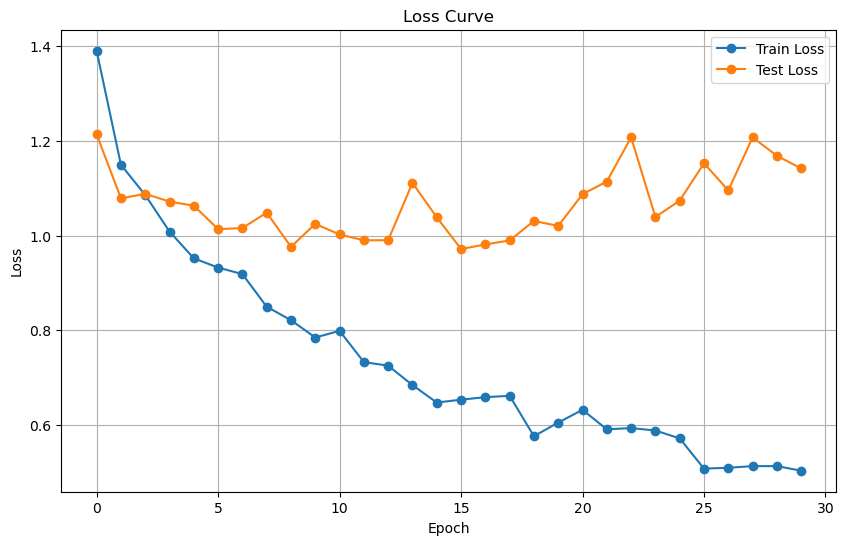

In [74]:
def plot_loss_curve(history: Dict[str, float]):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['test_loss'], label='Test Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curve(model_results)


In [75]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model: nn.Module,
                          dataloader: DataLoader,
                          device: torch.device,
                          class_names: list) -> None:
    model.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for images, labels in tqdm(dataloader, desc='Predicting...'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()

Predicting...: 100%|███████████████████| 16/16 [00:08<00:00,  1.80it/s]


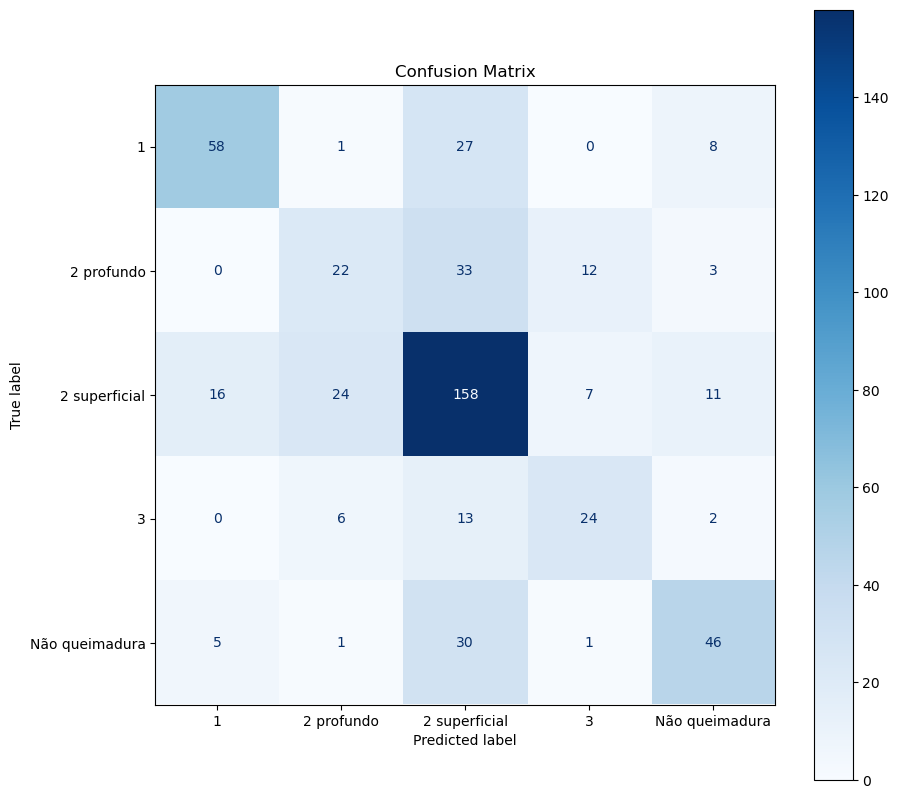

In [76]:
# Plotting the confusion matrix
plot_confusion_matrix(model, test_loader, device, class_names)